In [2]:
import pandas as pd
import numpy as np
import openml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline # moduł pipeline
from sklearn.impute import SimpleImputer # moduł imputacji braków danych
from sklearn.preprocessing import OneHotEncoder, StandardScaler # moduł przetwarzania danych
from smac import HyperparameterOptimizationFacade, Scenario
from smac.utils.logging import get_logger
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter, CategoricalHyperparameter
from sklearn import set_config
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.base import clone
import os
import ast

set_config(transform_output = "pandas")

In [4]:
# Datasets
openml_ids = {
    "phoneme": 1489,
    "bank-marketing": 1461,
    "blood-transfusion": 1464,
    "qsar-biodeg": 1494,
    "phishing-websites": 4534,
}

In [ ]:
# Datasets info
output = []
for key in openml_ids.keys():
    id = openml_ids[key]
    dataset = openml.datasets.get_dataset(id)
    X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
    X, y = shuffle(X, y, random_state=42)
    y = (y == y.unique()[1]).astype(int)
    row = {"dataset": key, "nrows": X.shape[0], "ncols": X.shape[1], "class_percentage": np.mean(y)}
    output.append(row)
pd.DataFrame(output)

,dataset,nrows,ncols,class_percentage
0,phoneme,5404,5,0.293486
1,bank-marketing,45211,16,0.116985
2,blood-transfusion,748,4,0.237968
3,qsar-biodeg,1055,41,0.662559
4,phishing-websites,11055,30,0.556943


In [5]:
# Models and hiperparameters
models = {
    "RandomForest": (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 150, 200, 300, 350],
        'clf__max_depth': [None, 5, 7, 10, 15, 20, 25],
        'clf__min_samples_split': list(range(2,60,5)),
        'clf__min_samples_leaf': [0.01, 0.05, 0.1, 0.15],
    }),
    "NeuralNetwork": (MLPClassifier(solver="adam",
                                    max_iter=800,
    ), {
        'clf__hidden_layer_sizes': [(50,), (100,), (100,50), (100,100)],
        'clf__activation': ["relu", "logistic"],
        'clf__alpha': [float(np.power(2.0,i)) for i in range(-10,8,1)],
    }),
    "LogReg": (LogisticRegression(solver="saga", max_iter=1500), {
        'clf__C': [float(np.power(2.0,i)) for i in range(-10,11,1)],
        'clf__penalty': ["l1", "l2", "elasticnet", None],
        "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
    })
}

In [6]:
# Pipelines
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy="median")),
    ('scale', StandardScaler())
    ])

## Categorical pipeline
cat_pipeline= Pipeline(steps = [
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

## ColumnTransformer
### pozwala na podział kolumn na podzbiory i przeprowadzanie operacji na pozdbiorach
col_trans = ColumnTransformer(
    transformers=[
    (
        "numeric_preprocessing",
        num_pipeline,
        make_column_selector(dtype_include=np.number),
    ),
    (
        "categorical_preprocessing",
        cat_pipeline,
        make_column_selector(dtype_include='category'),
    ),
    ],
remainder="passthrough", ## jak procesowane sa kolumny, ktore nie zostaly wybrane w liscie operacji
)


In [ ]:
# Tuning function with Grid Search
def grid_tuning_per_dataset_and_model(dataset_name_from_openml, model_name, frac=1, openml_ids=openml_ids, models=models, transformator=col_trans):

    id = openml_ids[dataset_name_from_openml]
    dataset = openml.datasets.get_dataset(id)
    X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
    X, y = shuffle(X, y, random_state=42)
    y = (y == y.unique()[1]).astype(int)

    # Split na train i test - stały zbiór testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    # Split który uwzględnia jakich procent danych bierzemy - podpunkt w opisie projektu
    if frac < 1:
        X_train, X_trash, y_train, y_trash = train_test_split(X_train, y_train, stratify=y_train, test_size=1-frac, random_state=42)

    model, param_grid = models[model_name]
    pipe = Pipeline(steps=[
        ("preprocess", transformator),
        ("clf", model)
    ])

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="balanced_accuracy",
        n_jobs=-1,
        refit=True
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    best_config_result = search.best_params_
    best_config_result = {k: [v] for k, v in search.best_params_.items()}
    best_config_result["cv_score"] = [float(search.best_score_)]
    best_config_result["test_score"] = [balanced_accuracy_score(y_test, y_pred)]

    best_config = pd.DataFrame(best_config_result)
    tuning_data = pd.DataFrame(search.cv_results_)

    os.makedirs("Dane_tuning", exist_ok=True)
    best_config.to_csv(f"Dane_tuning/best_config_{dataset_name_from_openml}_{model_name}_{frac}_Grid.csv", index=False)
    tuning_data.to_csv(f"Dane_tuning/tuning_data_{dataset_name_from_openml}_{model_name}_{frac}_Grid.csv", index=False)

    files.download(f"Dane_tuning/best_config_{dataset_name_from_openml}_{model_name}_{frac}_Grid.csv")
    files.download(f"Dane_tuning/tuning_data_{dataset_name_from_openml}_{model_name}_{frac}_Grid.csv")

    print(f"The best hyperparameter configuration search results: \n dataset: {dataset_name_from_openml} \n model_name: {model_name} \n frac: {frac} \n config: {search.best_params_}")


In [ ]:
# Tuning function with Bayesian Optimization SMAC3
def bayes_tuning_per_dataset_and_model(dataset_name_from_openml, model_name, frac, transformator=col_trans, n_trials=100):
    id = openml_ids[dataset_name_from_openml]
    dataset = openml.datasets.get_dataset(id)
    X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
    X, y = shuffle(X, y, random_state=42)
    y = (y == y.unique()[1]).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    if frac < 1:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=1 - frac, random_state=42)

    model, param_grid = models[model_name]
    pipe = Pipeline(steps=[
        ("preprocess", transformator),
        ("clf", model)
    ])

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cs = ConfigurationSpace()
    for param, values in param_grid.items():
        if all(isinstance(v, (int, np.integer)) for v in values):
            cs.add_hyperparameter(UniformIntegerHyperparameter(param, lower=min(values), upper=max(values)))
        elif all(isinstance(v, (float, np.floating)) for v in values):
            cs.add_hyperparameter(UniformFloatHyperparameter(param, lower=min(values), upper=max(values)))
        else:
            cs.add_hyperparameter(CategoricalHyperparameter(param, choices=values))


    def objective(config, seed=None, **kwargs):
        try:
            pipe.set_params(**config)

            if seed is not None:
                local_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=int(seed))
            else:
                local_cv = cv

            scores = cross_val_score(pipe, X_train, y_train, cv=local_cv, scoring="balanced_accuracy", n_jobs=-1)
            mean_score = np.mean(scores)

            return 1 - mean_score
        except Exception as e:
            print(f" Exception in objective: {e}")
            return 1.0

    scenario = Scenario(
        cs,
        deterministic=True,
        n_trials=n_trials
    )

    smac = HyperparameterOptimizationFacade(
        scenario=scenario,
        target_function=objective,
        overwrite=True
    )

    incumbent = smac.optimize()

    best_params = incumbent.get_dictionary()
    best_score_cv = 1 - smac.runhistory.get_cost(incumbent)

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_score = balanced_accuracy_score(y_test, y_pred)

    best_config_result = {k: [v] for k, v in best_params.items()}
    best_config_result["cv_score"] = [float(best_score_cv)]
    best_config_result["test_score"] = [float(test_score)]
    best_config = pd.DataFrame(best_config_result)

    all_runs = []
    for trial_key, trial_value in smac.runhistory.items():
      try:
        config = smac.runhistory.get_config(trial_key.config_id)
        cdict = dict(config)
        cdict["cv_score"] = 1 - trial_value.cost
        all_runs.append(cdict)
      except KeyError:
        continue

    tuning_data = pd.DataFrame(all_runs)

    os.makedirs("Dane_tuning", exist_ok=True)
    best_config.to_csv(f"Dane_tuning/best_config_{dataset_name_from_openml}_{model_name}_{frac}_Bayes.csv", index=False)
    tuning_data.to_csv(f"Dane_tuning/tuning_data_{dataset_name_from_openml}_{model_name}_{frac}_Bayes.csv", index=False)

    files.download(f"Dane_tuning/best_config_{dataset_name_from_openml}_{model_name}_{frac}_Bayes.csv")
    files.download(f"Dane_tuning/tuning_data_{dataset_name_from_openml}_{model_name}_{frac}_Bayes.csv")

    print(f"The best hyperparameter configuration search results: \n dataset: {dataset_name_from_openml} \n model_name: {model_name} \n frac: {frac} \n config: {best_params}")


In [ ]:
# Tuning loop
for model_name in ["RandomForest", "NeuralNetwork", "LogReg"]:
  for dataset in ["phoneme", "bank-marketing", "blood-transfusion", "qsar-biodeg", "phishing-websites"]:
    for frac in [0.25, 0.5, 0.75, 1]:
      grid_tuning_per_dataset_and_model(dataset, model_name, frac=frac)
      bayes_tuning_per_dataset_and_model(dataset, model_name, frac=frac)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The best hyperparameter configuration search results: 
 dataset: phishing-websites 
 model_name: RandomForest 
 frac: 0.25 
 config: {'clf__max_depth': None, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 37, 'clf__n_estimators': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The best hyperparameter configuration search results: 
 dataset: phishing-websites 
 model_name: RandomForest 
 frac: 0.5 
 config: {'clf__max_depth': 7, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The best hyperparameter configuration search results: 
 dataset: phishing-websites 
 model_name: RandomForest 
 frac: 0.75 
 config: {'clf__max_depth': 7, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The best hyperparameter configuration search results: 
 dataset: phishing-websites 
 model_name: RandomForest 
 frac: 1 
 config: {'clf__max_depth': 10, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}


In [ ]:
# Reading tuned data and preparing for searching best overall config
def read_tuning_data(model_name, frac):
    folder = "Dane_tuning"
    prefix = "tuning_data"
    files = [f for f in os.listdir(folder) if f.startswith(prefix) and model_name in f and str(frac) in f]
    results = pd.DataFrame()
    counter = 0
    for file in files:
        counter +=1
        new_data = pd.read_csv(f"Dane_tuning/{file}")
        new_data = new_data[["params", "cv_score"]]
        new_data.columns = ["params", f"mean_test_score_{counter}"]
        if results.empty:
            results["params"] = new_data["params"]
        results = pd.merge(results, new_data, on="params", how="inner")
    return results, counter


def fix_param_types(param_str):
    if isinstance(param_str, str):
        try:
            param_dict = ast.literal_eval(param_str)
        except Exception:
            return param_str
    elif isinstance(param_str, dict):
        param_dict = param_str
    else:
        return param_str

    new_dict = {}
    for k, v in param_dict.items():
        if isinstance(v, float) and v.is_integer():
            v = int(v)
        elif isinstance(v, str):
            if v.lower() == "none":
                v = None
            elif v.lower() == "true":
                v = True
            elif v.lower() == "false":
                v = False
            else:
                try:
                    parsed = ast.literal_eval(v)
                    v = parsed
                except Exception:
                    pass
        new_dict[k] = v
    return str(new_dict)


def read_tuning_data_bayes(model_name, frac):
    folder = "Dane_tuning"
    prefix = "tuning_data"
    files = [f for f in os.listdir(folder) if f.startswith(prefix) and model_name in f and str(frac) in f]
    results = pd.DataFrame()
    counter = 0

    for file in files:
        counter += 1
        new_data = pd.read_csv(os.path.join(folder, file))
        if "params" in new_data.columns:
            new_data["params"] = new_data["params"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        else:
            hyper_cols = [c for c in new_data.columns if not c.lower().startswith("cv")]
            new_data["params"] = new_data[hyper_cols].apply(lambda row: row.to_dict(), axis=1)
            new_data = new_data[["params", "cv_score"]]
        new_data.columns = ["params", f"cv_score_{counter}"]
        new_data["params"] = new_data["params"].apply(str)
        if results.empty:
            results = new_data.copy()
        else:
            results = pd.merge(results, new_data, on="params", how="inner")
    results["params"] = results["params"].apply(fix_param_types)
    return results, counter


def safe_eval_param(s):
    if isinstance(s, dict):
        return s
    if not isinstance(s, str):
        return {}
    try:
        val = ast.literal_eval(s)
        if isinstance(val, dict):
            return val
        else:
            return {}
    except Exception:
        return {}

def train_and_evaluate_best_overall_config(model_name, best_params, frac, transformator):
    scores = []
    datasets = []
    for key in openml_ids.keys():
        id = openml_ids[key]
        dataset = openml.datasets.get_dataset(id)
        X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
        X, y = shuffle(X, y, random_state=42)
        y = (y == y.unique()[1]).astype(int)
        # Split na train i test - stały zbiór testowy
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
        # Split który uwzględnia jakich procent danych bierzemy - podpunkt w opisie projektu
        if frac < 1:
            X_train, X_trash, y_train, y_trash = train_test_split(X_train, y_train, stratify=y_train, test_size=1-frac, random_state=42)

        model, param_grid = models[model_name]
        pipe = Pipeline(steps=[
        ("preprocess", transformator),
        ("clf", model)
        ])
        pipe.set_params(**best_params)
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        ba_test = balanced_accuracy_score(y_test, preds)
        datasets.append(key)
        scores.append(ba_test)
    overall_best_config_eval_on_datasets = pd.DataFrame({"datasets": datasets, "test_BA": scores})
    overall_best_config_eval_on_datasets.to_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_overall_test_ba_{model_name}_{frac}_Bayes.csv", index=False)

In [ ]:
### Funkcja wyznacza najlepszą konfiguracje hiperparametrów na podstawie średniej z wyników danego modelu na wszystkich przeliczonych
### zbiorach danych przy ustalonej frakcji np. 0.5 (ważne - zawsze odkładam 20% zbioru na test i dopiero z 80% biorę frakcję do treningu
### np. dla frac = 0.5, modele trenowane są na 0.5 * 0.8 = 0.4 , czyli na 40% oryginalnego zbioru)

# Funkcja zapisuje 3 pliki:
# -> mean_scores_whole_model_frakcja - wyniki tunowania dla każdej konfiguracji hiperparametrów uśrednione po wszystkich zbiorach przy ustalonej frakcji
# -> best_config_whole_model_frakcja - zapisuje kombinacje hiperparametrów które uzyskały najlepszy uśredniony wynik po wszystkich zbiorach (przy ustalonej frakcji),
#    oraz wynik (balanced accuracy) - uwaga: domyślnie modele trenowane są na pierwszej kombinacji nawet jeśli scory będą takie same dla paru innych kombinacji
# -> best_config_overall_test_model_frakcja - zapisuje wyniki najlepszej kombinacji (uśrednionej po zbiorach przy ustalonej frakcji) na zbiorze testowym (każdym z osobna)

def get_optimal_default_configurations_for_model(model_name, frac=1, transformator=col_trans):
    results, counter = read_tuning_data_bayes(model_name, frac)
    cols_to_average = [f"cv_score_{i+1}" for i in range(counter)]  # list of column indices
    results["mean_from_datasets"] = results[cols_to_average].mean(axis=1)
    results.sort_values(by="mean_from_datasets", ascending=False, inplace=True)
    results = results.reset_index(drop=True)
    results = results[["params", "mean_from_datasets"]]
    results.to_csv(f"Najlepsze_hiperparams_dla_modelu/mean_scores_whole_{model_name}_{frac}_Bayes.csv", index=False)

    best_configs = results.loc[results["mean_from_datasets"] == results["mean_from_datasets"][0]]
    best_configs = best_configs.reset_index(drop=True)
    best_configurations = [safe_eval_param(x) for x in best_configs["params"]]

    best_configs_for_model_type = pd.DataFrame(best_configurations)
    best_configs_for_model_type["mean_cv_BA"] = best_configs["mean_from_datasets"]
    best_configs_for_model_type.to_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_whole_{model_name}_{frac}_Bayes.csv", index=False)

    train_and_evaluate_best_overall_config(model_name, best_params=best_configurations[0], frac=frac, transformator=transformator)

    output = best_configurations[0]
    output["mean_from_datasets"] = float(results["mean_from_datasets"][0])
    return output

In [ ]:
# General optimal defualts loop
os.makedirs("Najlepsze_hiperparams_dla_modelu", exist_ok=True)
for model_name in ["RandomForest", "NeuralNetwork", "LogReg"]:
  for frac in [0.25, 0.5, 0.75, 1]:
    get_optimal_default_configurations_for_model(model_name=model_name, frac=frac)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logisti

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Obtaining data from files
results_test = []
results_cv = []

for model_name in ["LogReg", "RandomForest", "NeuralNetwork"]:
    for method in ["Grid", "Bayes"]:
        for frac in [0.25, 0.5, 0.75, 1]:

            overall_df = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_overall_test_ba_{model_name}_{frac}_{method}.csv")

            for dataset in overall_df["datasets"]:

                dataset_df = pd.read_csv(f"Dane_tuning/best_config_{dataset}_{model_name}_{frac}_{method}.csv")

                test_score_dataset = dataset_df["test_score"].iloc[0]
                test_score_overall = overall_df.loc[overall_df["datasets"] == dataset, "test_BA"].values[0]
                diff = test_score_overall - test_score_dataset

                results_test.append({
                    "model": model_name,
                    "method": method,
                    "fraction": frac,
                    "dataset": dataset,
                    "diff_test": diff
                })

            best_mean_cv_df = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_whole_{model_name}_{frac}_{method}.csv")
            mean_cv_df = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/mean_scores_whole_{model_name}_{frac}_{method}.csv")

            best_mean_cv = best_mean_cv_df["mean_cv_BA"].iloc[0]
            mean_cv_df["diff_cv"] = mean_cv_df["mean_from_datasets"] - best_mean_cv
            n_iter = len(mean_cv_df)

            for diff in mean_cv_df["diff_cv"]:
                results_cv.append({
                    "model": model_name,
                    "method": method,
                    "fraction": frac,
                    "diff_cv": diff,
                    "n_iter": n_iter
                })

df_test = pd.DataFrame(results_test)
df_cv = pd.DataFrame(results_cv)

print("Zebrane dane (test):", df_test.shape)
print("Zebrane dane (CV):", df_cv.shape)
display(df_test.head())
display(df_cv.head())

Zebrane dane (test): (120, 5)
Zebrane dane (CV): (10760, 5)


,model,method,fraction,dataset,diff_test
0,LogReg,Grid,0.25,phoneme,-0.001577
1,LogReg,Grid,0.25,bank-marketing,0.000188
2,LogReg,Grid,0.25,blood-transfusion,-0.027778
3,LogReg,Grid,0.25,qsar-biodeg,0.003471
4,LogReg,Grid,0.25,phishing-websites,0.000198


,model,method,fraction,diff_cv,n_iter
0,LogReg,Grid,0.25,0.000000,420
1,LogReg,Grid,0.25,-0.000008,420
2,LogReg,Grid,0.25,-0.000008,420
3,LogReg,Grid,0.25,-0.000008,420
4,LogReg,Grid,0.25,-0.000008,420


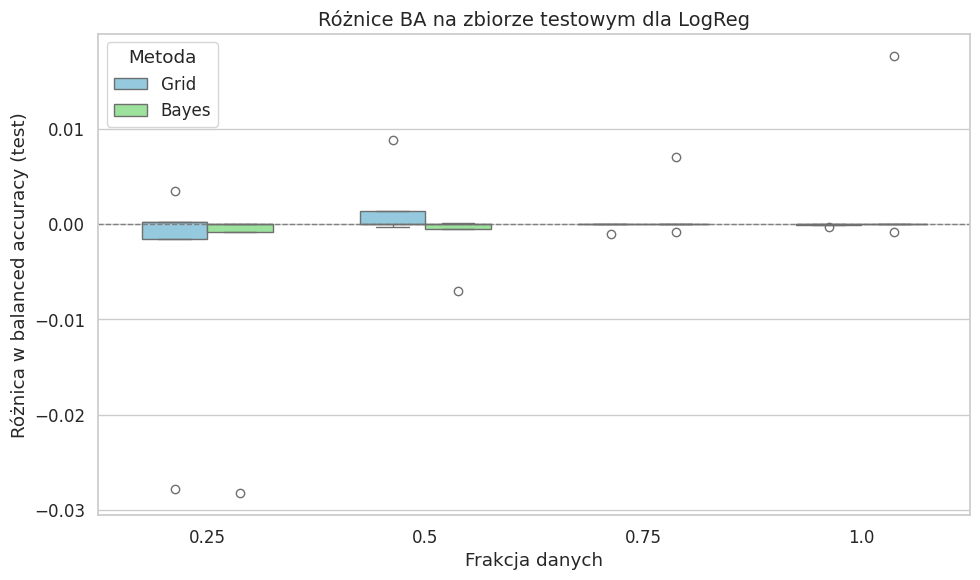

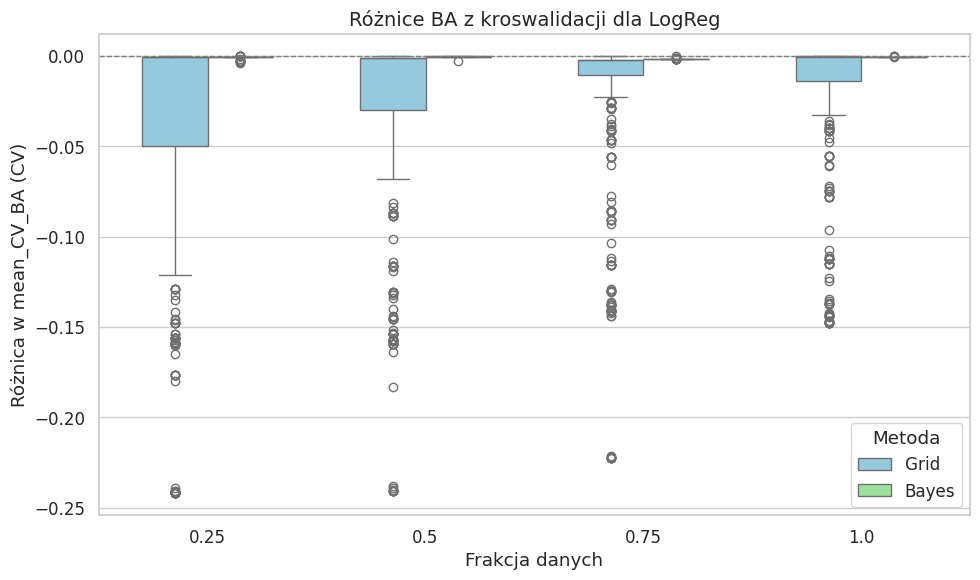

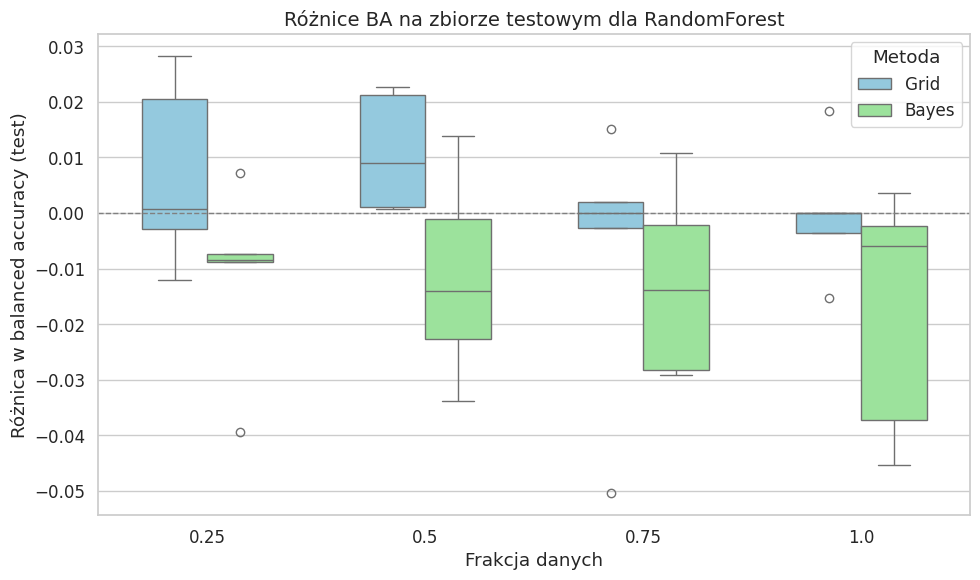

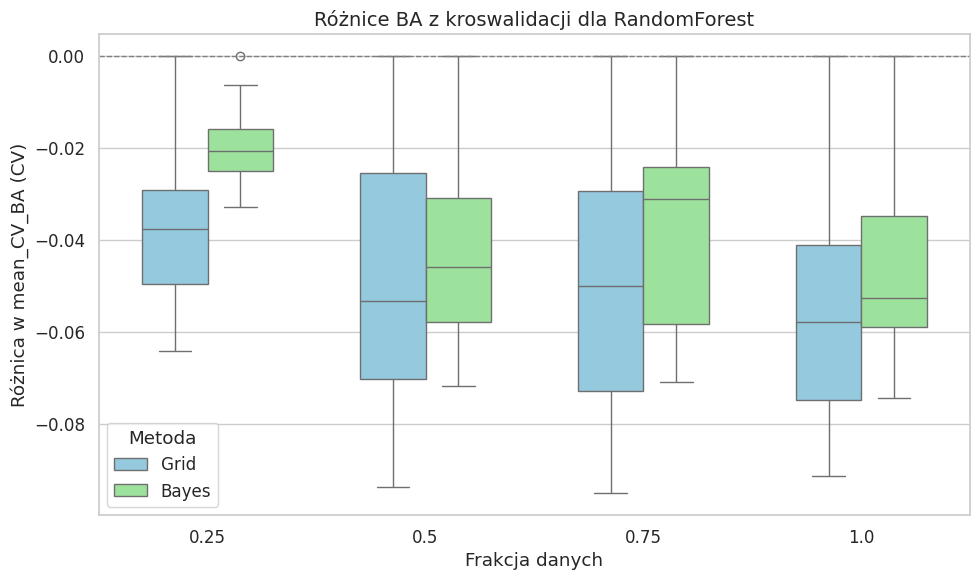

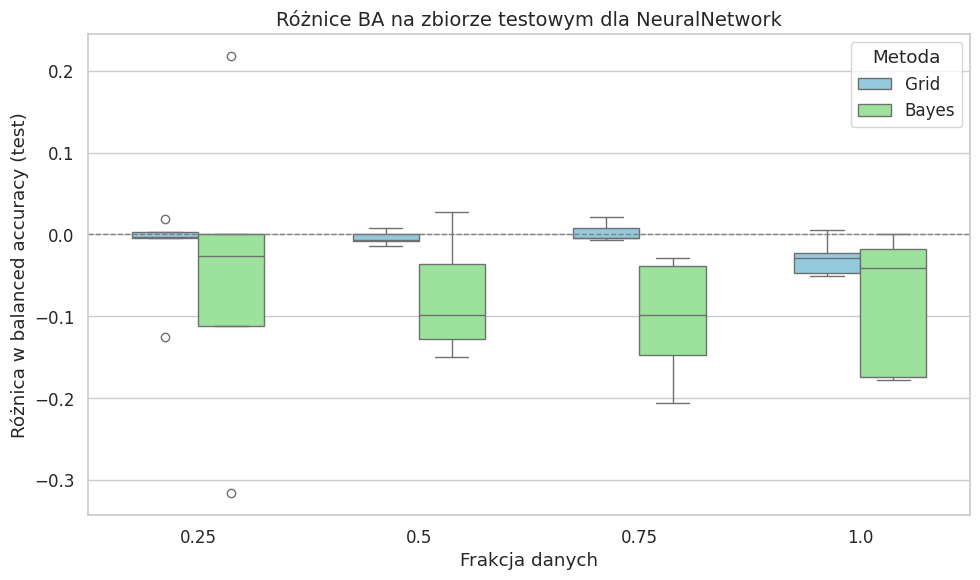

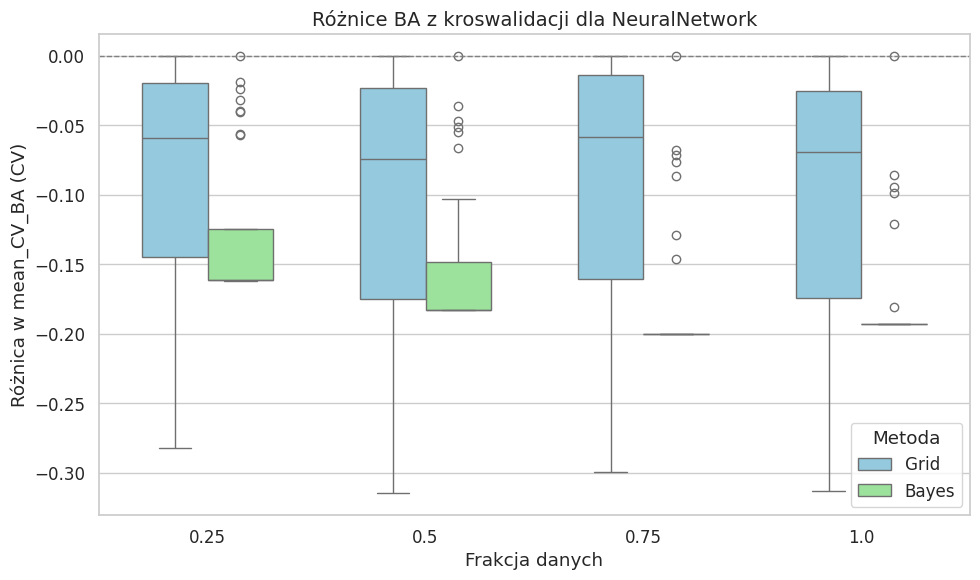

In [ ]:
# Tuning history distribution plots
sns.set(style="whitegrid", font_scale=1.1)

for model_name in ["LogReg", "RandomForest", "NeuralNetwork"]:

    plt.figure(figsize=(10,6))
    data_test = df_test[df_test["model"] == model_name]

    sns.boxplot(
        data=data_test,
        x="fraction",
        y="diff_test",
        hue="method",
        palette={"Grid": "skyblue", "Bayes": "lightgreen"},
        width=0.6
    )

    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Różnice BA na zbiorze testowym dla {model_name}", fontsize=14)
    plt.xlabel("Frakcja danych")
    plt.ylabel("Różnica w balanced accuracy (test)")
    plt.legend(title="Metoda", loc="best")
    plt.tight_layout()

    plt.savefig(f"Plots/roznice_test_{model_name}.png", dpi=300)
    plt.show()


    plt.figure(figsize=(10,6))
    data_cv = df_cv[df_cv["model"] == model_name]

    sns.boxplot(
        data=data_cv,
        x="fraction",
        y="diff_cv",
        hue="method",
        palette={"Grid": "skyblue", "Bayes": "lightgreen"},
        width=0.6
    )

    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(f"Różnice BA z kroswalidacji dla {model_name}", fontsize=14)
    plt.xlabel("Frakcja danych")
    plt.ylabel("Różnica w mean_CV_BA (CV)")
    plt.legend(title="Metoda", loc="best")
    plt.tight_layout()

    plt.savefig(f"Plots/roznice_cv_{model_name}.png", dpi=300)
    plt.show()

In [ ]:
df_cv["n_iter"].unique()

array([ 420,   41,   37, 2016,   38,   40,   39,  144,   35,   31,   30])

In [7]:
# New default hyperparams configurations and scores on crossvalidation
for model_name in ["LogReg", "RandomForest", "NeuralNetwork"]:
  rows = []
  for frac in [0.25, 0.5, 0.75, 1]:

    row = {"fraction" : frac}
    grid_dict = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_whole_{model_name}_{frac}_Grid.csv").iloc[0].to_dict()
    bayes_dict = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_whole_{model_name}_{frac}_Bayes.csv").iloc[0].to_dict()

    params = set(grid_dict.keys())
    params.discard("mean_cv_BA")

    for p in sorted(params):
      row[f"{p}_grid"] = grid_dict.get(p, None)
      row[f"{p}_bayes"] = bayes_dict.get(p, None)

    row["mean_cv_BA_grid"] = grid_dict.get("mean_cv_BA", None)
    row["mean_cv_BA_bayes"] = bayes_dict.get("mean_cv_BA", None)

    rows.append(row)

  df = pd.DataFrame(rows)
  out_path = os.path.join('Najlepsze_hiperparams_dla_modelu', f"best_params_{model_name}.csv")
  df.to_csv(out_path, index=False)
  print(f"Model: {model_name}:")
  display(df)

Model: LogReg:


,fraction,clf__C_grid,clf__C_bayes,clf__l1_ratio_grid,clf__l1_ratio_bayes,clf__penalty_grid,clf__penalty_bayes,mean_cv_BA_grid,mean_cv_BA_bayes
0,0.25,4.0,273.284322,0.90,0.596452,elasticnet,l1,0.742142,0.735607
1,0.50,2.0,22.194590,0.50,0.243704,elasticnet,elasticnet,0.741392,0.740348
2,0.75,2.0,5.234297,0.25,0.228802,elasticnet,elasticnet,0.726192,0.731306
3,1.00,2.0,5.234297,0.10,0.228802,l2,elasticnet,0.731327,0.728245


Model: RandomForest:


,fraction,clf__max_depth_grid,clf__max_depth_bayes,clf__min_samples_leaf_grid,clf__min_samples_leaf_bayes,clf__min_samples_split_grid,clf__min_samples_split_bayes,clf__n_estimators_grid,clf__n_estimators_bayes,mean_cv_BA_grid,mean_cv_BA_bayes
0,0.25,25.0,15.0,0.01,0.021989,2.0,3.0,200.0,147.0,0.716100,0.698007
1,0.50,10.0,7.0,0.01,0.019920,17.0,24.0,100.0,71.0,0.742098,0.736247
2,0.75,10.0,NaN,0.01,0.011309,17.0,36.0,150.0,151.0,0.739254,0.728667
3,1.00,15.0,NaN,0.01,0.011309,7.0,36.0,50.0,151.0,0.734375,0.725964


Model: NeuralNetwork:


,fraction,clf__activation_grid,clf__activation_bayes,clf__alpha_grid,clf__alpha_bayes,clf__hidden_layer_sizes_grid,clf__hidden_layer_sizes_bayes,mean_cv_BA_grid,mean_cv_BA_bayes
0,0.25,relu,relu,0.000977,8.016622,"(100, 100)","(100, 100)",0.782616,0.661275
1,0.50,relu,relu,0.015625,8.016622,"(100, 50)","(100, 100)",0.814241,0.683134
2,0.75,relu,relu,0.000977,8.016622,"(100,)","(100, 100)",0.799514,0.700439
3,1.00,relu,relu,0.125000,8.016622,"(100, 50)","(100, 100)",0.813121,0.692971


In [3]:
# Scores on test
for model_name in ["LogReg", "RandomForest", "NeuralNetwork"]:
  rows = []
  i = 0
  for dataset_name in ["phoneme", "bank-marketing", "blood-transfusion", "qsar-biodeg", "phising-websites"]:

    row = {"dataset" : dataset_name}
    for frac in [0.25, 0.5, 0.75, 1]:
      grid_scores = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_overall_test_ba_{model_name}_{frac}_Grid.csv")
      bayes_scores = pd.read_csv(f"Najlepsze_hiperparams_dla_modelu/best_config_overall_test_ba_{model_name}_{frac}_Bayes.csv")
      row[f"{frac}_grid"] = round(grid_scores["test_BA"].iloc[i], 3)
      row[f"{frac}_bayes"] = round(bayes_scores["test_BA"].iloc[i], 3)

    rows.append(row)
    i += 1

  df = pd.DataFrame(rows)
  print(f"Model: {model_name}:")
  display(df)

Model: LogReg:


,dataset,0.25_grid,0.25_bayes,0.5_grid,0.5_bayes,0.75_grid,0.75_bayes,1_grid,1_bayes
0,phoneme,0.703,0.703,0.710,0.710,0.708,0.708,0.700,0.700
1,bank-marketing,0.659,0.659,0.671,0.672,0.669,0.669,0.666,0.666
2,blood-transfusion,0.601,0.629,0.677,0.668,0.556,0.556,0.552,0.552
3,qsar-biodeg,0.841,0.813,0.827,0.820,0.859,0.859,0.862,0.880
4,phising-websites,0.925,0.924,0.934,0.931,0.932,0.932,0.931,0.931


Model: RandomForest:


,dataset,0.25_grid,0.25_bayes,0.5_grid,0.5_bayes,0.75_grid,0.75_bayes,1_grid,1_bayes
0,phoneme,0.798,0.758,0.808,0.768,0.817,0.779,0.825,0.778
1,bank-marketing,0.504,0.500,0.528,0.500,0.525,0.500,0.502,0.500
2,blood-transfusion,0.656,0.654,0.701,0.683,0.627,0.608,0.636,0.632
3,qsar-biodeg,0.806,0.802,0.824,0.781,0.827,0.827,0.820,0.813
4,phising-websites,0.905,0.900,0.912,0.907,0.912,0.909,0.915,0.909


Model: NeuralNetwork:


,dataset,0.25_grid,0.25_bayes,0.5_grid,0.5_bayes,0.75_grid,0.75_bayes,1_grid,1_bayes
0,phoneme,0.846,0.718,0.856,0.716,0.851,0.712,0.828,0.695
1,bank-marketing,0.714,0.555,0.728,0.579,0.720,0.566,0.707,0.560
2,blood-transfusion,0.604,0.500,0.674,0.528,0.697,0.500,0.632,0.519
3,qsar-biodeg,0.848,0.500,0.841,0.736,0.876,0.827,0.844,0.830
4,phising-websites,0.937,0.915,0.953,0.911,0.952,0.925,0.959,0.917
